# Navier-Stokes Equation
## A 2+1 Dimensional Numerical Experiment of FNOs

This notebook walks through the Fourier Neural Operator for a 2D problem such as the Navier-Stokes discussed in Section 5.3 in the paper [Fourier Neural Operator for
Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf) which uses a recurrent structure to propagates in time.

In [1]:
from typing import Any, Callable, Generic, NamedTuple, Optional, Tuple, TypeVar

import yaml
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer

from torch.nn.functional import mse_loss
import torch

from neuralop import count_params
from neuralop.datasets import load_navier_stokes_temporal_pt
from neuralop.layers import SpectralConv2d
from neuralop.models import FNO2d
from neuralop.training import LpLoss

torch.manual_seed(0)
np.random.seed(0)

In [2]:
#################################################
# Utilities
#################################################
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [3]:
################################################################
# fourier layer
################################################################
print(
"""
The overall network. It contains 4 layers of the Fourier layer.
1. Lift the input to the desire channel dimension by self.fc0 .
2. 4 layers of the integral operators u' = (W + K)(u).
    W defined by self.w; K defined by self.conv .
3. Project from the channel space to the output space by self.fc1 and self.fc2 .

input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
input shape: (batchsize, x=64, y=64, c=12)
output: the solution of the next timestep
output shape: (batchsize, x=64, y=64, c=1)
"""
)


The overall network. It contains 4 layers of the Fourier layer.
1. Lift the input to the desire channel dimension by self.fc0 .
2. 4 layers of the integral operators u' = (W + K)(u).
    W defined by self.w; K defined by self.conv .
3. Project from the channel space to the output space by self.fc1 and self.fc2 .

input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
input shape: (batchsize, x=64, y=64, c=12)
output: the solution of the next timestep
output shape: (batchsize, x=64, y=64, c=1)



In [6]:
class Config(NamedTuple):
    data_path: str
    n_train: int
    n_test: int
    train_batch_size: int
    test_batch_size: int
    learning_rate: float
    epochs: int
    iterations: int
    modes: int
    width: int
    subsampling_rate: int
    s: int
    history_length: int
    future_duration: int
    step: int
        
    @staticmethod
    def from_yaml(config_path: str):
        with open(config_path, 'r') as f:
            cfg = yaml.load(f)

        config = Config(
            data_path=cfg['data_path'],
            n_train=cfg['n_train'],
            n_test=cfg['n_test'],
            train_batch_size=cfg['train_batch_size'],
            test_batch_size=cfg['test_batch_size'],
            learning_rate=cfg['learning_rate'],
            epochs=cfg['epochs'],
            iterations=cfg['iterations'],
            modes=cfg['modes'],
            width=cfg['width'],
            subsampling_rate=cfg['subsampling_rate'],
            s=cfg['s'],
            history_length=cfg['history_length'],
            future_duration=cfg['future_duration'],
            step=cfg['step'],
        )        
        return config


config = Config.from_yaml('fourier_2d_time_V1e-4.yaml')

In [8]:
################################################################
# load data and data normalization
################################################################

train_loader, test_loader, output_encoder = load_navier_stokes_temporal_pt(
    config.data_path,
    config.n_train,
    config.n_test,
    config.history_length,
    config.future_duration,
    config.train_batch_size,
    config.test_batch_size,
)

UnitGaussianNormalizer init on 2000, reducing over [0, 1, 2, 3], samples of shape [10, 64, 64].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
UnitGaussianNormalizer init on 2000, reducing over [0, 1, 2, 3], samples of shape [20, 64, 64].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05


In [9]:
model = FNO2d(
    config.modes,  # modes_width
    config.modes,  # modes_height
    config.width,  # width of all hidden layers
    # input channels are 12: the solution of the previous 10 timesteps + 2 location encodings
    # i.e: (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
    in_channels=2 + config.history_length,
    out_channels=1,  # output channel is 1: u(t, x, y)
    n_layers=4,
    # domain_padding=8,
    domain_padding=None,
    # domain_padding_mode='one-sided',
    use_mlp=True,
).cuda()
print(f"Model parameter count: {count_params(model):,d}")

Model parameter count: 239,773


In [10]:
################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.iterations
)
lp_loss = LpLoss()  # By default, does not do size averaging
output_encoder.cuda()

header_strings = (
    'Epoch',
    'Duration',
    'Training L2 (step)',
    'Training L2 (full)',
    'Testing L2 (step)',
    'Testing L2 (full)',
)
HEADER = ' | '.join(header_strings)
for ep in range(config.epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for train_data in train_loader:
        xx = train_data['x'].to(device)
        yy = train_data['y'].to(device)
        loss = 0

        # For each time step
        for t in range(0, config.future_duration, config.step):
            # We want the operator to learn the next S time steps:
            y = yy[:, t:t + config.step, ...]
            # use recurrent structure to propagate in time:
            im = model(xx)
            loss += lp_loss(
                im.reshape(config.train_batch_size, -1),
                y.reshape(config.train_batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), 1)

            # Advance the recurrent input by one time step; i.e:
            # [t_n, ..., t_{n+m}] --> [t_{n+s}, ..., t_{n+s+m}]
            # for starting time N, future duraiton M, and time step S
            xx = torch.cat((
                xx[..., config.step:-2, :, :],  # [t_{n+s}, ..., t_{n+m}]
                im,                             # [t_{n+m+1}, ..., t_{n+m+s}]
                xx[..., -2:, :, :]              # positional encoding
            ), dim=1)

        # Compare the full, operator-predicted future with the ground truth.
        # This is not used in training, but surfaces how well 
        # the operator has done overall in this epoch.
        train_l2_step += loss.item()
        l2_full = lp_loss(
            pred.reshape(config.train_batch_size, -1), 
            yy.reshape(config.train_batch_size, -1))
        train_l2_full += l2_full.item()

        # Backprop based only on the loss for each step-by-step in time.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    model.eval()
    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        for test_data in test_loader:
            xx = test_data['x'].to(device)
            yy = test_data['y'].to(device)
            loss = 0

            for t in range(0, config.future_duration, config.step):
                y = yy[:, t:t + config.step, ...]
                im = model(xx)
                loss += lp_loss(
                    im.reshape(config.test_batch_size, -1), 
                    y.reshape(config.test_batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), 1)

                xx = torch.cat((
                    xx[..., config.step:-2, :, :],  # [t_{n+s}, ..., t_{n+m}]
                    im,                             # [t_{n+m+1}, ..., t_{n+m+s}]
                    xx[..., -2:, :, :]              # positional encoding
                ), dim=1)

            test_l2_step += loss.item()
            test_l2_full += lp_loss(
                pred.reshape(config.test_batch_size, -1), 
                yy.reshape(config.test_batch_size, -1)).item()

    t2 = default_timer()
    train_l2_step_normed = train_l2_step / config.n_train / (config.future_duration / config.step)
    train_l2_full_normed = train_l2_full / config.n_train
    test_l2_step_normed = test_l2_step / config.n_test / (config.future_duration / config.step)
    test_l2_full_normed = test_l2_full / config.n_test
    if ep % 20 == 0:
        print(HEADER)
    row = ' | '.join(
        [f'{ep:{len(header_strings[0])}d}', f'{t2 - t1:{len(header_strings[1])}.3f}'] + 
        [f'{x:{len(s)}.6f}' for s, x
         in zip(header_strings[2:], (train_l2_step_normed,
                                     train_l2_full_normed,
                                     test_l2_step_normed,
                                     test_l2_full_normed))])
    print(row)

Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
    0 |   21.121 |           0.825828 |           0.856234 |          0.709917 |          0.753082
    1 |   20.746 |           0.635211 |           0.688778 |          0.605225 |          0.643865
    2 |   20.764 |           0.506951 |           0.552464 |          0.560502 |          0.602080
    3 |   20.852 |           0.433629 |           0.479538 |          0.519445 |          0.556100
    4 |   21.075 |           0.385933 |           0.426109 |          0.493440 |          0.523191
    5 |   20.853 |           0.354541 |           0.392446 |          0.484249 |          0.509236
    6 |   20.920 |           0.329532 |           0.366051 |          0.470945 |          0.493334
    7 |   21.245 |           0.312480 |           0.349055 |          0.464619 |          0.487186
    8 |   20.867 |           0.295913 |           0.330986 |          0.463088 |          0.483050
    9 |   

   79 |   20.887 |           0.178857 |           0.208765 |          0.409375 |          0.419150
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
   80 |   21.394 |           0.180561 |           0.211378 |          0.410258 |          0.420005
   81 |   21.575 |           0.177026 |           0.206438 |          0.411726 |          0.421715
   82 |   20.987 |           0.178715 |           0.208544 |          0.407935 |          0.418334
   83 |   21.351 |           0.177056 |           0.206910 |          0.411331 |          0.422027
   84 |   20.995 |           0.176592 |           0.206067 |          0.411049 |          0.420878
   85 |   21.543 |           0.178191 |           0.208603 |          0.407733 |          0.417787
   86 |   20.956 |           0.177039 |           0.206874 |          0.404949 |          0.414855
   87 |   20.954 |           0.174680 |           0.203606 |          0.409633 |          0.419529
   88 |   

  158 |   20.961 |           0.158244 |           0.186176 |          0.398695 |          0.406645
  159 |   21.120 |           0.156056 |           0.182944 |          0.398527 |          0.406580
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  160 |   20.953 |           0.154396 |           0.180581 |          0.397899 |          0.405847
  161 |   21.139 |           0.154892 |           0.181383 |          0.392875 |          0.400756
  162 |   21.561 |           0.158977 |           0.187190 |          0.404443 |          0.412623
  163 |   21.597 |           0.153980 |           0.180039 |          0.399546 |          0.407475
  164 |   21.494 |           0.153939 |           0.180177 |          0.398614 |          0.406446
  165 |   21.563 |           0.156922 |           0.184727 |          0.404235 |          0.412850
  166 |   20.897 |           0.157217 |           0.185308 |          0.399211 |          0.406792
  167 |   

  237 |   21.174 |           0.143056 |           0.167627 |          0.397347 |          0.404543
  238 |   21.247 |           0.146582 |           0.172761 |          0.394740 |          0.401683
  239 |   21.087 |           0.144375 |           0.169685 |          0.399315 |          0.406794
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  240 |   21.020 |           0.143289 |           0.168068 |          0.394382 |          0.401405
  241 |   21.389 |           0.142721 |           0.167309 |          0.397591 |          0.404869
  242 |   21.367 |           0.143510 |           0.168460 |          0.396086 |          0.402987
  243 |   21.064 |           0.142787 |           0.167482 |          0.397546 |          0.405305
  244 |   21.530 |           0.142650 |           0.167285 |          0.394407 |          0.401461
  245 |   21.270 |           0.143290 |           0.168323 |          0.392928 |          0.400065
  246 |   

  316 |   20.940 |           0.135897 |           0.159189 |          0.396419 |          0.403073
  317 |   20.967 |           0.136212 |           0.159777 |          0.392860 |          0.399509
  318 |   21.134 |           0.135945 |           0.159368 |          0.392368 |          0.398811
  319 |   20.990 |           0.136082 |           0.159590 |          0.391183 |          0.397745
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  320 |   21.468 |           0.136240 |           0.159854 |          0.389592 |          0.396014
  321 |   20.910 |           0.135974 |           0.159410 |          0.394967 |          0.401758
  322 |   21.564 |           0.135861 |           0.159279 |          0.393630 |          0.400132
  323 |   21.280 |           0.135650 |           0.158961 |          0.392743 |          0.399137
  324 |   20.993 |           0.135897 |           0.159399 |          0.391879 |          0.398367
  325 |   

  395 |   20.979 |           0.132126 |           0.154807 |          0.392556 |          0.398858
  396 |   21.589 |           0.132261 |           0.155039 |          0.391995 |          0.398187
  397 |   20.940 |           0.132121 |           0.154810 |          0.391571 |          0.397820
  398 |   21.479 |           0.132058 |           0.154741 |          0.391278 |          0.397487
  399 |   21.277 |           0.131955 |           0.154586 |          0.392577 |          0.398884
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  400 |   20.964 |           0.131977 |           0.154639 |          0.392868 |          0.399165
  401 |   20.973 |           0.131911 |           0.154562 |          0.391401 |          0.397582
  402 |   21.107 |           0.131884 |           0.154512 |          0.391779 |          0.397920
  403 |   21.504 |           0.131904 |           0.154557 |          0.390789 |          0.396933
  404 |   

  475 |   20.978 |           0.130741 |           0.153149 |          0.391733 |          0.397939
  476 |   21.305 |           0.130729 |           0.153132 |          0.391940 |          0.398145
  477 |   21.294 |           0.130729 |           0.153134 |          0.391531 |          0.397710
  478 |   21.198 |           0.130726 |           0.153128 |          0.391821 |          0.398033
  479 |   21.041 |           0.130727 |           0.153135 |          0.391587 |          0.397767
Epoch | Duration | Training L2 (step) | Training L2 (full) | Testing L2 (step) | Testing L2 (full)
  480 |   21.491 |           0.130717 |           0.153117 |          0.391321 |          0.397494
  481 |   21.492 |           0.130719 |           0.153118 |          0.391841 |          0.398036
  482 |   21.317 |           0.130710 |           0.153110 |          0.391577 |          0.397764
  483 |   20.992 |           0.130708 |           0.153105 |          0.391741 |          0.397928
  484 |   

In [11]:
class TB(NamedTuple):
    """Truth (& Beauty)"""
    index: int
    """Index of the source datapoint in the overall testing dataset."""
    truth: torch.Tensor
    beauty: torch.Tensor
    error: torch.Tensor


def sample_test_data(
    dataloader: torch.utils.data.DataLoader,
    index: int,
    sample_fn: Callable[[torch.Tensor], int],
) -> Tuple[int, torch.Tensor, torch.Tensor]:
    """Returns a sampled index from the ith batch of the loader."""
    found_idx = None
    for i, data in enumerate(dataloader):
        if i != index:
            continue
        
        xx = data['x'].to(device)
        yy = data['y'].to(device)
        for t in range(0, config.future_duration, config.step):
            im = model(xx)
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), 1)

            xx = torch.cat((
                xx[..., config.step:-2, :, :],  # [t_{n+s}, ..., t_{n+m}]
                im,                             # [t_{n+m+1}, ..., t_{n+m+s}]
                xx[..., -2:, :, :]              # positional encoding
            ), dim=1)
        
        error = (pred - yy).square()
        found_idx = sample_fn(error)
        return TB(found_idx, yy[found_idx], pred[found_idx], error[found_idx])

    return found_idx

## Visualization

Visualize the error in the trained model against a subsample of testing data points. Also visualize the error (squared to be non-negative).

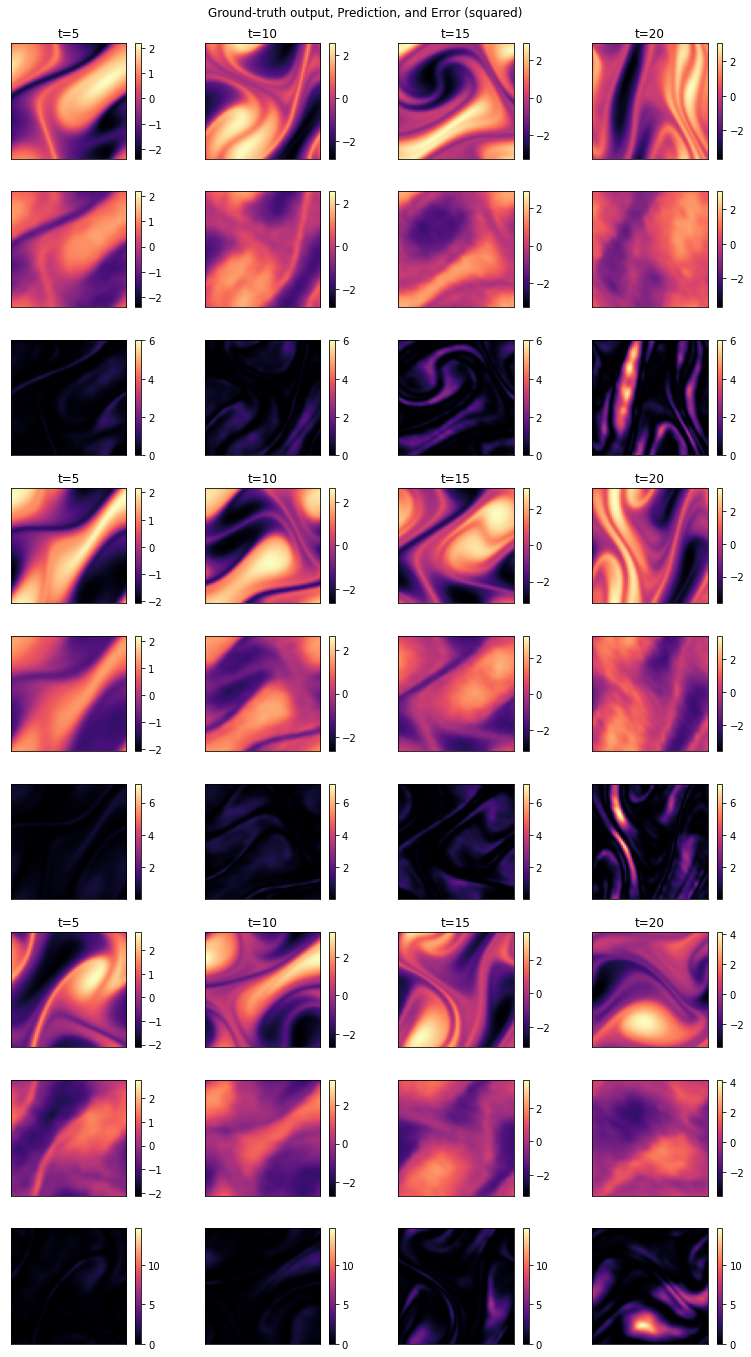

In [15]:
# test_samples = test_loader.dataset
n_samples = 3
n_rows = 3
n_cols = 4
t_step = 5

def sample_largest_error(error: torch.Tensor) -> int:
    m = [error[i].max() for i in range(error.shape[0])]
    mi = max(enumerate(m), key=lambda x: x[1])
    return mi[0]

fig = plt.figure(figsize=(11,  # width (inches)
                          19))  # height (inches)
for sample in range(n_samples):
    batch_number = 20 + 2 * sample
    _, yy, pred, error = sample_test_data(
        test_loader, batch_number, sample_largest_error)
    # pred *= 2
    # error = (pred - yy).square()

    vmin = [
        min(yy[i].min(), pred[i].min())
        for i in range(4, config.future_duration, t_step)
    ] 
    vmax = [
        max(yy[i].max(), pred[i].max())
        for i in range(4, config.future_duration, t_step)
    ] 

    # Ground truth:
    r = sample * n_rows
    for c in range(n_cols):
        t = (c + 1) * t_step - 1
        ax = fig.add_subplot(n_rows * n_samples, n_cols, r * n_cols + c + 1)
        im = ax.imshow(yy[t].cpu(),
                       cmap='magma', 
                       vmin=vmin[c], 
                       vmax=vmax[c])
        ax.set_title(f't={t + 1}')
        plt.xticks([], [])
        plt.yticks([], [])
        fig.colorbar(im, ax=ax)

    # Model prediction:
    r = sample * n_rows + 1
    for c in range(n_cols):
        t = (c + 1) * t_step - 1
        ax = fig.add_subplot(n_rows * n_samples, n_cols, r * n_cols + c + 1)
        im = ax.imshow(pred[t].detach().cpu(),
                       cmap='magma', 
                       vmin=vmin[c], 
                       vmax=vmax[c])
        plt.xticks([], [])
        plt.yticks([], [])
        fig.colorbar(im, ax=ax)

    # Error:
    r = sample * n_rows + 2
    for c in range(n_cols):
        t = (c + 1) * t_step - 1   
        ax = fig.add_subplot(n_rows * n_samples, n_cols, r * n_cols + c + 1)
        im = ax.imshow(error[t].detach().cpu(),
                       cmap='magma',
                       vmin=error.min(),
                       vmax=error.max())
        # print(f'{error[t].min():7.5f} <= error[t] <= {error[t].max():7.5f}')
        plt.xticks([], [])
        plt.yticks([], [])
        fig.colorbar(im, ax=ax)

fig.suptitle('Ground-truth output, Prediction, and Error (squared)', y=0.99)
plt.tight_layout()
fig.show()